In [1]:
import imageio
import torch
from IPython.display import clear_output
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PyQt5
%matplotlib inline

In [2]:
frame_sample_rate = 10
videosList=[]
for vidIdx in range(7):
    vidCv2 = cv2.VideoCapture(f'data/usliverseq-mp4/volunteer{str(vidIdx+1).zfill(2)}.mp4')
    frameIdx = 0
    frames = []
    while(vidCv2.isOpened()):
        ret, frame = vidCv2.read()
        if ret == True and frameIdx % frame_sample_rate == 0:
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            frames.append(frame)
        if ret == False:
            break
        frameIdx+=1

    #number of frames in video:
    print(f'volunteer{str(vidIdx+1).zfill(2)}.mp4:\n')
    print("number of frames:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_COUNT)))
    #frame size:
    print("frame size:" ,int(vidCv2.get(cv2.CAP_PROP_FRAME_WIDTH)), "x", int(vidCv2.get(cv2.CAP_PROP_FRAME_HEIGHT)),'\n')

    
    video = np.stack(frames, axis=0)
    videosList.append(video)

    cv2.destroyAllWindows()
    

volunteer01.mp4:

number of frames: 14516
frame size: 640 x 480 

volunteer02.mp4:

number of frames: 4372
frame size: 712 x 480 

volunteer03.mp4:

number of frames: 4625
frame size: 700 x 480 

volunteer04.mp4:

number of frames: 4078
frame size: 720 x 540 

volunteer05.mp4:

number of frames: 3983
frame size: 720 x 540 

volunteer06.mp4:

number of frames: 4943
frame size: 672 x 480 

volunteer07.mp4:

number of frames: 4593
frame size: 500 x 480 



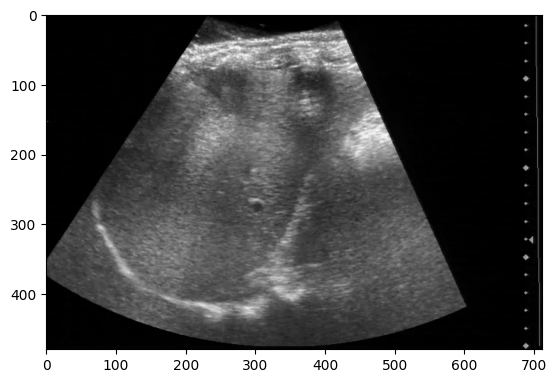

In [3]:
# Example on how to visualize frames in a video

videoIdx = 1 # Choose video to visualize
noFrames = 100 # Choose first noFrames to visualize

vidShow=videosList[videoIdx][:noFrames]
for i in range(noFrames):
    plt.imshow(vidShow[i],cmap='gray')
    plt.show()
    clear_output(wait=True)

(0.0, 1.0, 0.0, 1.0)

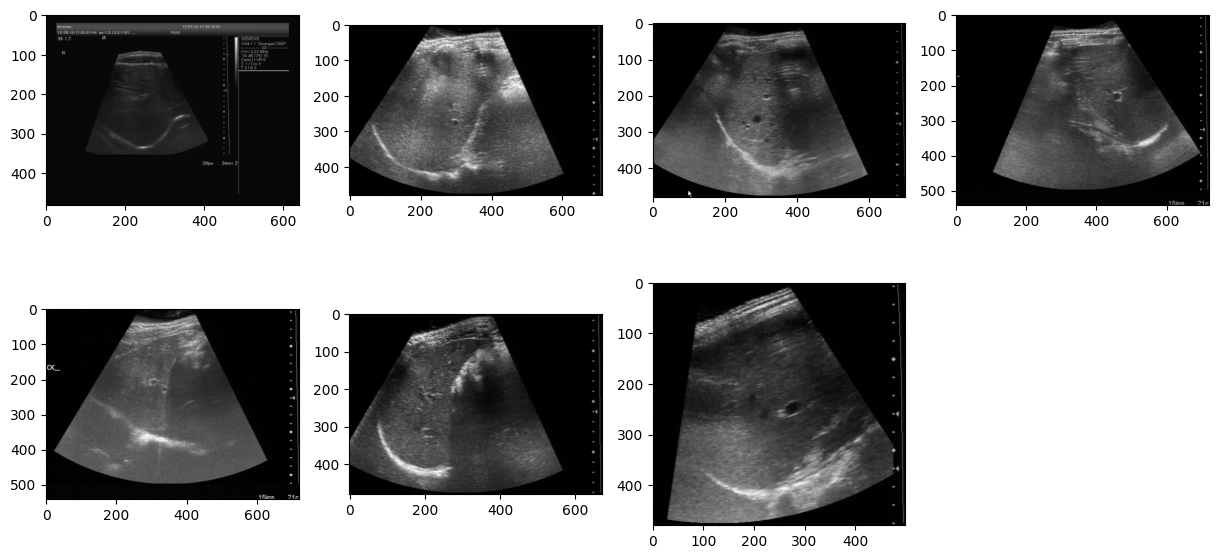

In [4]:
# Plot first frames of all videos
fig, ax = plt.subplots(2,4,figsize=(15,7))
ax=ax.ravel()
for idx,vid in enumerate(videosList):
    ax[idx].imshow(vid[0],cmap='gray')
ax[-1].axis('off')

In [5]:
# Switch to interactive mode
#%matplotlib qt 

# ptsList=[]
# for vidIdx in range(len(videosList)):
#     plt.imshow(videosList[vidIdx][0]>10,cmap='gray')
#     pts=plt.ginput(4)
#     ptsList.append(np.array(pts))
#     plt.show()
#     plt.close()
# ptsArray = np.array(ptsList).astype(np.float32)
# np.savez('transPts',ptsArray)

# Switch back to inline mode
#%matplotlib inline 

In [6]:
ptsArray = np.load('transPts.npz')["arr_0"]
print(ptsArray.shape)

(7, 4, 2)


In [7]:
# We agree on a reference video which all other videos are transformed to, video 2, i.e. video index 1
refIdx=1
_ , refRows, refCols = videosList[refIdx].shape
refPts = ptsArray[refIdx]

videosTransList = []

for videoIdx,video in enumerate(videosList):
    if videoIdx!=refIdx:
        transPts = ptsArray[videoIdx]
        M = cv2.getPerspectiveTransform(transPts, refPts)
        
        framesTransList = []
        for frameIdx,frame in enumerate(video):
            frameTrans = cv2.warpPerspective(frame, M, (refCols, refRows))
            framesTransList.append(frameTrans)

        videosTransList.append(np.array(framesTransList))
    else: 
        # Append reference frame video without affine transformation
        videosTransList.append(video)

(0.0, 1.0, 0.0, 1.0)

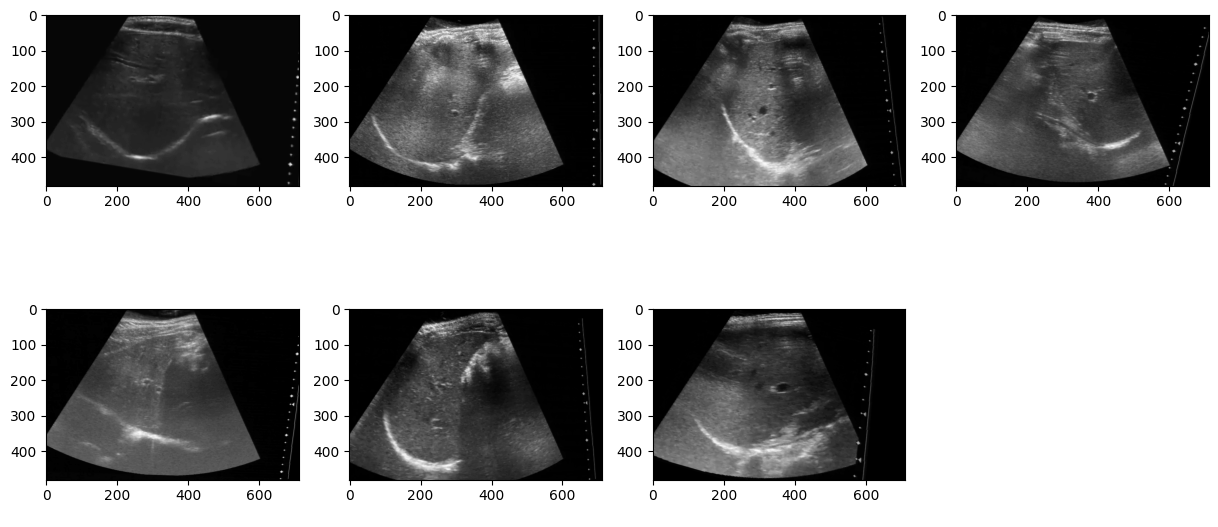

In [8]:
# Plot first frames of all transformed videos
fig, ax = plt.subplots(2,4,figsize=(15,7))
ax=ax.ravel()
for idx,vid in enumerate(videosTransList):
    ax[idx].imshow(vid[0],cmap='gray')
ax[-1].axis('off')

### Test on whether we should apply binary morphology or not to create mask too remove everything outside field of view

In [9]:
import skimage.morphology as morph
import skimage

element = np.array([[0,1,0],
                    [1,1,1],
                    [0,1,0]])
disk = np.zeros((40,40))
element = skimage.draw.disk((20,20),7,shape=(40,40))
disk[element]=1
                        
closedTest = morph.opening(videosTransList[2][0]>10,disk)

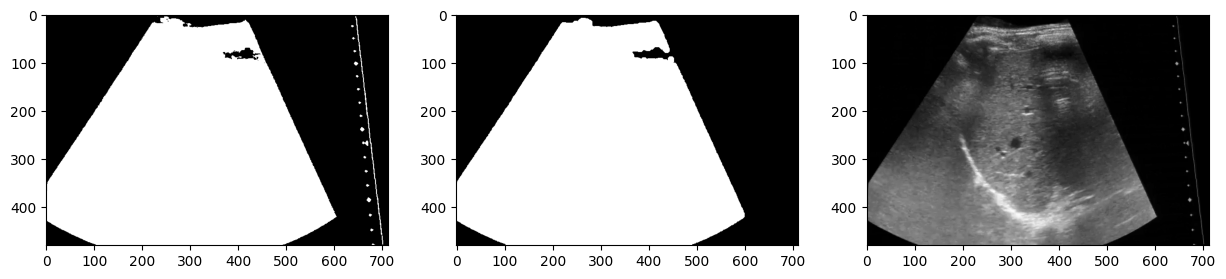

In [10]:
fig,ax=plt.subplots(1,3,figsize=(15,7))
ax[0].imshow(videosTransList[2][0]>10,cmap='gray')
ax[1].imshow(closedTest,cmap='gray')
ax[2].imshow(videosTransList[2][0],cmap='gray')